In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import STL10

import math
from PIL import Image, ImageFilter, ImageOps
import random
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
class Optimizer:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for idx, p in enumerate(self.params):
            if p.grad is None:
                continue
            self.update_param(p)

    def update_param(self, p):
        raise NotImplementedError


class SGD(Optimizer):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update)


class SGDMomentum(Optimizer):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum
        self.m_t = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.m_t[p] = self.momentum * self.m_t[p] + (1 - self.momentum) * p.grad
        p_update = -self.lr * self.m_t[p]
        p.add_(p_update)


class Adam(Optimizer):
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params}
        self.m_t = {p: torch.zeros_like(p.data) for p in self.params}
        self.v_t = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.m_t[p] = self.beta1 * self.m_t[p] + (1 - self.beta1) * p.grad
        self.v_t[p] = self.beta2 * self.v_t[p] + (1 - self.beta2) * p.grad**2

        bias_correction_m_t = 1 - self.beta1 ** self.param_step[p]
        bias_correction_v_t = 1 - self.beta2 ** self.param_step[p]

        m_hat = self.m_t[p] / bias_correction_m_t
        v_hat = self.v_t[p] / bias_correction_v_t
        lr = self.lr / (torch.sqrt(v_hat) + self.eps)

        p_update = -lr * m_hat

        p.add_(p_update)

In [ ]:
def attention_function(query, key, value, mask=None):
    d_k = query.shape[-1] * 1.0
    # (batch_size, num_heads, seq_len, seq_len)
    logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        # When logit is set to -inf, softmax(logit) = 0, which is what we want
        logits = logits.masked_fill_(mask == 0, -float("inf"))

    attention = nn.Softmax(dim=-1)(logits)
    values = torch.matmul(attention, value)
    return values, attention


class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        d_query,
        d_key,
        d_value,
        d_model,
        num_heads,
        attention_function=attention_function,
    ):
        assert d_model % num_heads == 0, "d_model must be 0 modulo num_heads."
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.attention_function = attention_function
        self.query_linear = nn.Linear(d_query, d_model)
        self.key_linear = nn.Linear(d_key, d_model)
        self.value_linear = nn.Linear(d_value, d_model)
        self.output_linear = nn.Linear(d_model, d_model)

    def get_heads(self, x):
        batch_len, seq_len = x.shape[0], x.shape[1]
        x = x.reshape(
            batch_len, seq_len, self.num_heads, self.d_model // self.num_heads
        )
        x = x.permute(0, 2, 1, 3)
        return x

    def forward(self, query, key, value, mask=None, return_attention=False):
        query_batch_len, query_seq_len = query.shape[0], query.shape[1]
        query = self.get_heads(self.query_linear(query))
        key = self.get_heads(self.key_linear(key))
        value = self.get_heads(self.value_linear(value))

        output, attention = self.attention_function(query, key, value, mask)
        output = output.permute(0, 2, 1, 3).reshape(
            (query_batch_len, query_seq_len, self.d_model)
        )
        output = self.output_linear(output)

        if not return_attention:
            return output
        return output, attention


class FeedForward(nn.Module):
    def __init__(self, d_input, d_feedforward):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(d_input, d_feedforward),
            nn.ReLU(),
            nn.Linear(d_feedforward, d_input),
        )

    def forward(self, x):
        return self.feed_forward(x)


class Encoder(nn.Module):
    def __init__(self, d_input, num_heads):
        super().__init__()
        self.self_attention = MultiHeadAttention(
            d_input, d_input, d_input, d_input, num_heads
        )
        self.layer_norm_1 = nn.LayerNorm(d_input)
        self.feed_forward = FeedForward(d_input, d_input * 4)
        self.layer_norm_2 = nn.LayerNorm(d_input)

    def forward(self, x, mask=None):
        # Pre-LN layer
        ln_x = self.layer_norm_1(x)
        x = x + self.self_attention(ln_x, ln_x, ln_x)
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x


class EncoderBlock(nn.Module):
    def __init__(self, num_encoders=6, **encoder_args):
        super().__init__()
        self.encoders = nn.ModuleList(
            [Encoder(**encoder_args) for _ in range(num_encoders)]
        )

    def forward(self, x, mask=None):
        for encoder in self.encoders:
            x = encoder(x, mask)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for encoder in self.encoders:
            _, attention_map = encoder.self_attention(
                x, x, x, mask, return_attention=True
            )
            attention_maps.append(attention_map)
            x = encoder(x)
        return attention_maps


class LinearProjection(nn.Module):
    def __init__(self, d_input, d_output):
        super().__init__()
        self.projection = nn.Linear(d_input, d_output)

    def forward(self, x):
        x = self.projection(x)
        return x


def convert_images_to_flat_patches(x, patch_size, flatten_channels=True):
    b, c, h, w = x.shape
    x = x.reshape(b, c, h // patch_size, patch_size, w // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # (b, h/p, w/p, c, p_h, p_w)
    x = x.flatten(1, 2)  # (b, h/p * w/p, c, p_h, p_w)
    if flatten_channels:
        x = x.flatten(2, 4)  # (b, h/p * w/p, c * p_h * p_w)
    return x


class VisionTransfomer(nn.Module):
    def __init__(
        self,
        d_model,
        num_encoders,
        num_heads,
        num_channels,
        patch_size,
        max_patches,
        num_classes,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.linear_projection = LinearProjection(
            num_channels * patch_size**2, d_model
        )
        self.encoders = EncoderBlock(
            d_input=d_model, num_encoders=num_encoders, num_heads=num_heads
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model), nn.Linear(d_model, num_classes)
        ) if num_classes > 0 else nn.Identity()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + max_patches, d_model))

    def forward(self, x):
        x = convert_images_to_flat_patches(x, self.patch_size)
        batch_size, num_patches, _ = x.shape
        x = self.linear_projection(x)  # batch, num_patches, d_model
        cls_token = self.cls_token.repeat(batch_size, 1, 1)
        # add a class token to every picture (that is now flat), one for each pic
        x = torch.cat([cls_token, x], dim=1)
        # add learnable positional embedding, one for the class token + per patch
        x = x + self.pos_embedding[:, 1 + num_patches]
        x = self.encoders(x)
        # classify the class token
        return self.mlp_head(x[:, 0])

In [ ]:
class DinoHead(nn.Module):
    def __init__(self, d_in, d_out, num_layers=3, d_hidden=2048, d_bottleneck=256):
        super().__init__()
        num_layers = max(1, num_layers)
        if num_layers == 1:
            self.mlp = LinearProjection(d_in, d_bottleneck)
        else:
            first_layer = LinearProjection(d_in, d_hidden)
            middle_layers = [
                LinearProjection(d_hidden, d_hidden) for _ in range(num_layers - 2)
            ]
            last_layer = LinearProjection(d_hidden, d_bottleneck)
            layers = [first_layer] + middle_layers + [last_layer]
            self.mlp = nn.Sequential(*layers)
        self.last_layer = LinearProjection(d_bottleneck, d_out)

    def forward(self, x):
        x = self.mlp(x)
        x = self.last_layer(x)
        return x


class RandomGaussianBlur:
  def __init__(self, p=0.5, min_radius=0.1, max_radius=2.):
    self.p = p
    self.min_radius = min_radius
    self.max_radius = max_radius

  def __call__(self, x):
    if random.random() < self.p:
      return x.filter(
        ImageFilter.GaussianBlur(
            radius=random.uniform(self.min_radius, self.max_radius)
        )
      )
    return x


class RandomSolarization:
  def __init__(self, p=0.5):
    self.p = p

  def __call__(self, x):
    if random.random() < self.p:
      return ImageOps.solarize(x)
    return x



class DinoDataAugmentation:
    def __init__(self, global_crops_scale, local_crops_scale, num_local_crops):
        flip_and_color_jitter = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1
                        )
                    ],
                    p=0.8,
                ),
                transforms.RandomGrayscale(p=0.2),
            ]
        )
        normalize = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        )

        self.global_transform_1 = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    224, scale=global_crops_scale, interpolation=Image.BICUBIC
                ),
                flip_and_color_jitter,
                RandomGaussianBlur(1.0),
                normalize,
            ]
        )
        self.global_transform_2 = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    224, scale=global_crops_scale, interpolation=Image.BICUBIC
                ),
                flip_and_color_jitter,
                RandomGaussianBlur(0.1),
                RandomSolarization(0.2),
                normalize,
            ]
        )

        self.num_local_crops = num_local_crops
        self.local_transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(
                    96, scale=local_crops_scale, interpolation=Image.BICUBIC
                ),
                flip_and_color_jitter,
                RandomGaussianBlur(p=0.5),
                normalize,
            ]
        )

    def __call__(self, image):
        crops = [self.global_transform_1(image), self.global_transform_2(image)]
        crops.extend([self.local_transform(image) for _ in range(self.num_local_crops)])
        return crops


class DinoLoss(nn.Module):
    def __init__(
        self,
        output_dim,
        student_temp,
        teacher_temp,
        centre_momentum,
        num_global_crops,
        num_local_crops,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.student_temp = student_temp
        # Ignore the scheduled teacher_temp set up for now.
        self.teacher_temp = teacher_temp
        self.centre_momentum = centre_momentum
        self.num_global_crops = num_global_crops
        self.num_local_crops = num_local_crops
        self.register_buffer("centre", torch.zeros(1, output_dim))

    @torch.no_grad()
    def update_centre(self, teacher_output):
        # Update centre.
        # Note that we calculate the batch mean of the original output, before the transformations we apply.
        batch_mean = torch.mean(teacher_output, dim=0, keepdim=True)
        self.centre = (
            self.centre_momentum * self.centre + (1 - self.centre_momentum) * batch_mean
        )

    def forward(self, student_output, teacher_output):
        assert student_output.shape[-1] == self.output_dim
        assert teacher_output.shape[-1] == self.output_dim

        # Chunk the outputs into one tensor per crop.
        student_out = F.softmax(student_output / self.student_temp).chunk(
            self.num_global_crops + self.num_local_crops
        )
        # Note that detaching here is important. But why?
        # Does this function as the stop gradient operator?
        teacher_out = (
            F.softmax((teacher_output - self.centre) / self.teacher_temp)
            .detach()
            .chunk(self.num_global_crops)
        )

        # Calculate cross entropy of every student output, with respect to every teacher output.
        loss = 0
        num_loss_terms = 0
        for t_idx, t in enumerate(teacher_out):
            for s_idx, s in enumerate(student_out):
                # Assumes that the global crops are first among the student outs.
                if s_idx == t_idx:
                    continue
                loss += torch.mean(t * F.log(s), dim=-1)
                num_loss_terms += 1
        loss /= num_loss_terms

        # Update the teacher centre.
        self.update_centre(teacher_output)

        return loss


class MultiCropWrapper(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # Group together any transformations that share the same resolution, and run them through the model backbone.
        # Then collect all the outputs across all the transformations, and run them all together through the head.
        # [dim1, dim1, dim2, dim3, dim3] => [2, 1, 2] => [2, 3, 5]
        crop_indices_grouped_by_resolution = torch.cumsum(
            torch.unique_consecutive(
                torch.tensor([inp.shape[-1] for inp in x]),
                return_counts=True,
            )[1],
            dim=0,
        )
        cursor = 0
        output = torch.empty(0)

        for end_idx in crop_indices_grouped_by_resolution:
            output = torch.cat([output, self.backbone(torch.cat(x[cursor:end_idx]))])
            cursor = end_idx

        return self.head(output)


def train_one_epoch(
    student, teacher, teacher_lambda, optimizer, loss_fn, num_global_crops, data_loader,
):
    for batch, _ in data_loader:
        student_output = student(batch)
        teacher_output = teacher(batch[:num_global_crops])
        loss = loss_fn(student_output, teacher_output)

        optimizer.zero_grad()

        # Update the student.
        loss.backward()
        optimizer.step()

        # Update the teacher.
        # Ignore the lambda rate schedule for now: use a constant value.
        with torch.no_grad():
            for param_s, param_t in zip(student.parameters(), teacher.parameters()):
                param_t.data.mul_(teacher_lambda).add_(
                    (1 - teacher_lambda) * param_s.detach().data
                )


def get_dino_data_loader(
    dataset,
    batch_size
  ):
  return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        pin_memory=True,
    )



def train_dino(
    student,
    teacher,
    dataset,
    teacher_lambda,
    batch_size,
    num_epochs,
    num_global_crops=2,
):
    for _ in range(num_epochs):
        train_one_epoch(
            student,
            teacher,
            teacher_lambda,
            optimizer,
            dino_loss,
            num_global_crops,
            data_loader=get_dino_data_loader(
                dataset,
                batch_size,
            ),
        )


d_model = 128
d_out = 64
optimizer_lr = 0.01
teacher_lambda = 0.99
num_local_crops = 4

student_backbone = VisionTransfomer(
    d_model=d_model,
    num_encoders=6,
    num_heads=4,
    num_channels=3,
    patch_size=8,
    max_patches=1000,
    num_classes=0,
)
student = MultiCropWrapper(
    backbone=student_backbone, head=DinoHead(d_in=d_model, d_out=d_out)
)

teacher_backbone = VisionTransfomer(
    d_model=d_model,
    num_encoders=6,
    num_heads=4,
    num_channels=3,
    patch_size=8,
    max_patches=1000,
    num_classes=0,
)
teacher = MultiCropWrapper(
    backbone=teacher_backbone, head=DinoHead(d_in=d_model, d_out=d_out)
)
for param in teacher.parameters():
    param.requires_grad = False

optimizer = Adam(student.parameters(), lr=optimizer_lr)

dino_loss = DinoLoss(
    output_dim=128,
    student_temp=0.1,
    teacher_temp=0.1,
    centre_momentum=0.9,
    num_global_crops=2,
    num_local_crops=num_local_crops,
)

In [ ]:
data = STL10(
    root="../augmented_data",
    split='unlabeled',
    download=True,
    transform=DinoDataAugmentation(
        global_crops_scale=(0.6, 1.0),
        local_crops_scale=(0.2, 0.4),
        num_local_crops=4,
    )
  )

KeyboardInterrupt: ignored

In [ ]:
data_loader = get_dino_data_loader(
    data,
    batch_size=8,
)

In [ ]:
train_dino(
    student=student,
    teacher=teacher,
    dataset=data,
    teacher_lambda=0.99,
    batch_size=8,
    num_epochs=1,
    num_global_crops=2,
)

In [ ]:
batch_1 = next(iter(data_loader))

In [ ]:
len(batch_1)

2

In [ ]:
b1 = batch_1[0]

In [ ]:
len(b1)

6

torch.Size([8, 3, 224, 224])


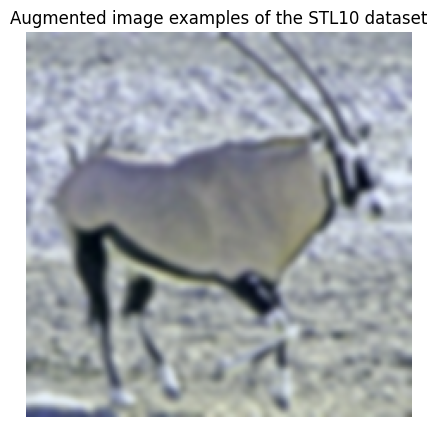

torch.Size([8, 3, 224, 224])


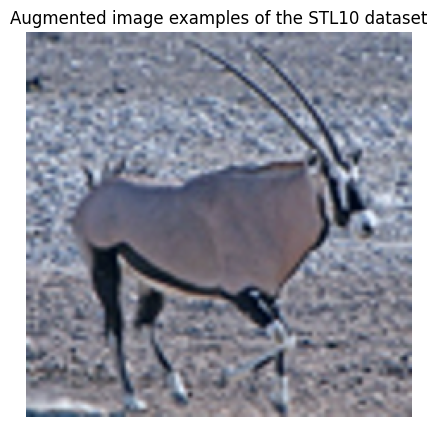

torch.Size([8, 3, 96, 96])


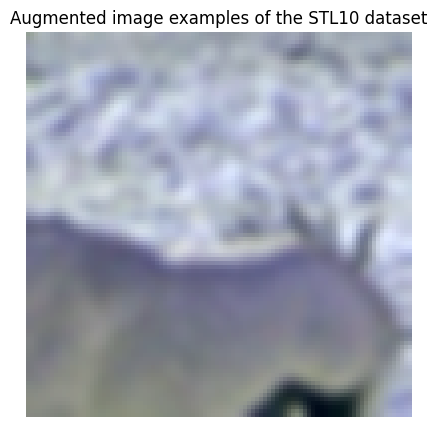

torch.Size([8, 3, 96, 96])


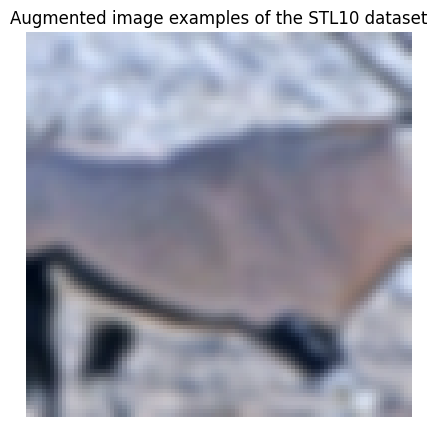

torch.Size([8, 3, 96, 96])


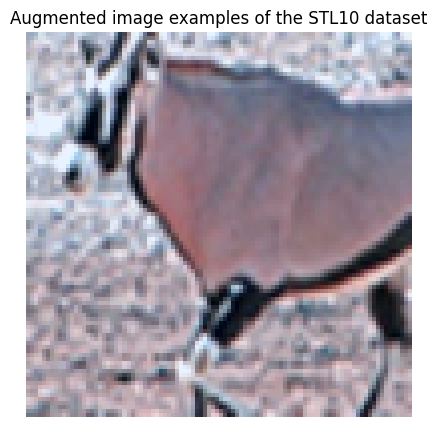

torch.Size([8, 3, 96, 96])


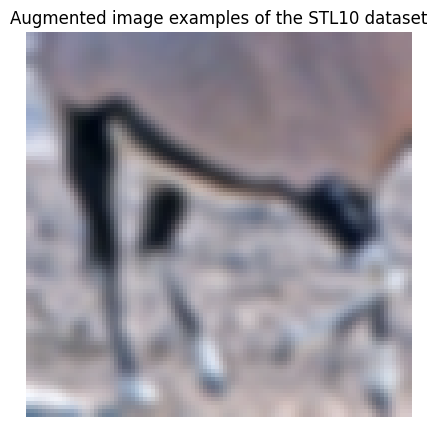

In [ ]:
import matplotlib.pyplot as plt

for b in b1:
  print(b.shape)
  im = b[1, :]
  low = im.min()
  high = im.max()
  plt.figure(figsize=(10,5))
  plt.title('Augmented image examples of the STL10 dataset')
  plt.imshow(im.permute(1, 2, 0).clamp_(low, high).sub_(low).div_(max(high - low, 1e-5)))
  plt.axis('off')
  plt.show()


In [ ]:
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()